In [5]:
!pip install qpsolvers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 3.8 MB/s 


# Imports

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from qpsolvers import solve_qp

# Helpers + Classes

In [7]:
class MySVM:

  def __init__(self, C=1.0, gamma=1.0, kernel_type='linear'):
    self.C = C
    self.gamma = gamma
    self.kernel_type = kernel_type

  def kernel(self, X1, X2, c=0.0, d=1.0):
    if self.kernel_type == 'linear':
      return np.dot(X1, np.transpose(X2)) + c 
    elif self.kernel_type == 'polynomial':
      return (np.dot(X1, np.transpose(X2)) + c) ^ d 
    elif self.kernel_type == 'rbf':
      if self.gamma == None:
        self.gamma = 1 / X1.shape[-1]  # 1 / D
      if (X1.ndim == 1) and (X2.ndim == 1):
        return np.exp(-self.gamma * np.linalg.norm(X1 - X2) ** 2)
      elif ((X1.ndim > 1) and (X2.ndim == 1)) or ((X1.ndim == 1) and (X2.ndim > 1)):
        return np.exp(-self.gamma * np.linalg.norm(X1- X2, axis=1) ** 2)
      elif (X1.ndim > 1) and (X2.ndim > 1):
        return np.exp(-self.gamma * np.linalg.norm(X1[:, np.newaxis] - X2[np.newaxis, :], axis=2) ** 2)
    elif self.kernel_type == 'sigmoid':
      return np.tanh(self.gamma * np.dot(X1, np.transpose(X2)) + c)

  def dualQP_fit(self):
    self.yI = np.zeros((2*(self.N_train + 1), self.N_train))
    self.yI[0, :] = self.y_train
    self.yI[1, :] = -self.y_train
    self.yI[2:self.N_train+2, :] = -np.identity(self.N_train)
    self.yI[self.N_train+2:, :] = np.identity(self.N_train)

    self.C0 = np.zeros(2*(self.N_train + 1))
    self.C0[self.N_train+2:] = self.C

    self.K = self.kernel(self.X_train, self.X_train)
    self.yy = np.outer(self.y_train, self.y_train)
    self.yyX = np.multiply(self.yy, self.K)

    self.alphas = solve_qp(self.yyX, -np.ones((self.N_train, 1)), self.yI, self.C0, solver=self.qp_solver)
    self.w = np.dot(np.transpose(self.X_train), np.multiply(self.alphas, self.y_train))  
    self.b = np.mean(self.y_train - np.dot(self.X_train, self.w))

  def dualGD_fit(self):
    self.K = self.kernel(self.X_train, self.X_train)
    self.yy = np.outer(self.y_train, self.y_train)
    self.yyX = np.multiply(self.yy, self.K)
    self.alphas = np.random.random(self.N_train)

    losses = list()
    for n_iter in range(self.n_iters):
      loss = np.sum(self.alphas) - 0.5 * np.dot(np.dot(np.transpose(self.alphas), self.yyX), self.alphas) 
      losses.append(loss)
      grad = np.ones(self.N_train) - np.dot(self.yyX, self.alphas)
      self.alphas += self.lr * grad
      self.alphas[self.alphas < 0] = 0
      self.alphas[self.alphas > self.C] = self.C

    self.w = np.dot(np.transpose(self.X_train), np.multiply(self.alphas, self.y_train))  
    self.b = np.mean(self.y_train - np.dot(self.X_train, self.w))

  def primalGD_fit(self):
    self.K = self.kernel(self.X_train, self.X_train)
    self.w = np.random.randn(self.N_train)
    self.b = 0

    losses = list()
    for n_iter in range(self.n_iters):
      margins = self.y_train * (np.dot(self.w, self.K) + self.b)
      loss = 0.5 * np.dot(self.w, np.dot(self.K, self.w)) + self.C * np.maximum(0, 1 - margins).sum()
      losses.append(loss)
      indexes = np.where(margins < 1)[0]
      grad_w = np.dot(self.K, self.w) - self.C * np.dot(self.y_train[indexes], self.K[indexes])
      grad_b = - self.C * np.sum(self.y_train[indexes])
      self.w -= self.lr * grad_w
      self.b -= self.lr * grad_b

  def fit(self, X, y, lr=None, n_iters=None, method=None, qp_solver='osqp'):
    self.X_train = X
    self.y_train = y
    self.lr = lr
    self.n_iters = n_iters
    self.method = method
    self.qp_solver = qp_solver
    self.N_train = self.X_train.shape[0]
    
    if self.method == 'dual_with_QP':
      self.dualQP_fit()
    elif self.method == 'dual_with_GD':
      self.dualGD_fit()
    elif self.method == 'primal_with_GD':
      self.primalGD_fit()

  def predict(self, X):
    if (self.method == 'dual_with_QP') or (self.method == 'dual_with_GD'):
      return np.sign(np.dot(np.multiply(self.alphas, self.y_train), self.kernel(self.X_train, X)) + self.b)
    elif self.method == 'primal_with_GD':
      return np.sign(np.dot(self.w, self.kernel(self.X_train, X)) + self.b)
    else:
      print("No method was used during training")

  def get_accuracy(self, y1, y2):
    return 100 * np.mean(y1 == y2)

In [8]:
def create_spiral_data(N):
  phi = 2 * np.pi * np.sqrt(np.random.rand(N))
  r1 = phi + np.pi
  r2 = - phi - np.pi

  X1 = np.array([r1 * np.cos(phi), r1 * np.sin(phi)]).T + np.random.rand(N, 2)
  X2 = np.array([r2 * np.cos(phi), r2 * np.sin(phi)]).T + np.random.rand(N, 2)
  y1 = np.ones((N, 1))
  y2 = -np.ones((N, 1))

  data = np.concatenate((np.concatenate((X1, X2), axis=0), np.concatenate((y1, y2), axis=0)), axis=1)
  np.random.shuffle(data)
  X = data[:, :-1]
  y = data[:, -1].flatten()

  return X, y


def scale(X_train, X_val, X_test):
  scaler = MinMaxScaler()
  X_train_scaled = scaler.fit_transform(X_train)
  X_val_scaled = scaler.transform(X_val)
  X_test_scaled = scaler.transform(X_test)

  return X_train_scaled, X_val_scaled, X_test_scaled


def plot_data(X, y):
  plt.figure(figsize=(30, 10))
  plt.scatter(X[:, 0], X[:, 1], c=y)
  plt.title('Spiral data - 2D')
  plt.xlabel('x1')
  plt.ylabel('x2')
  plt.show()

# MAIN

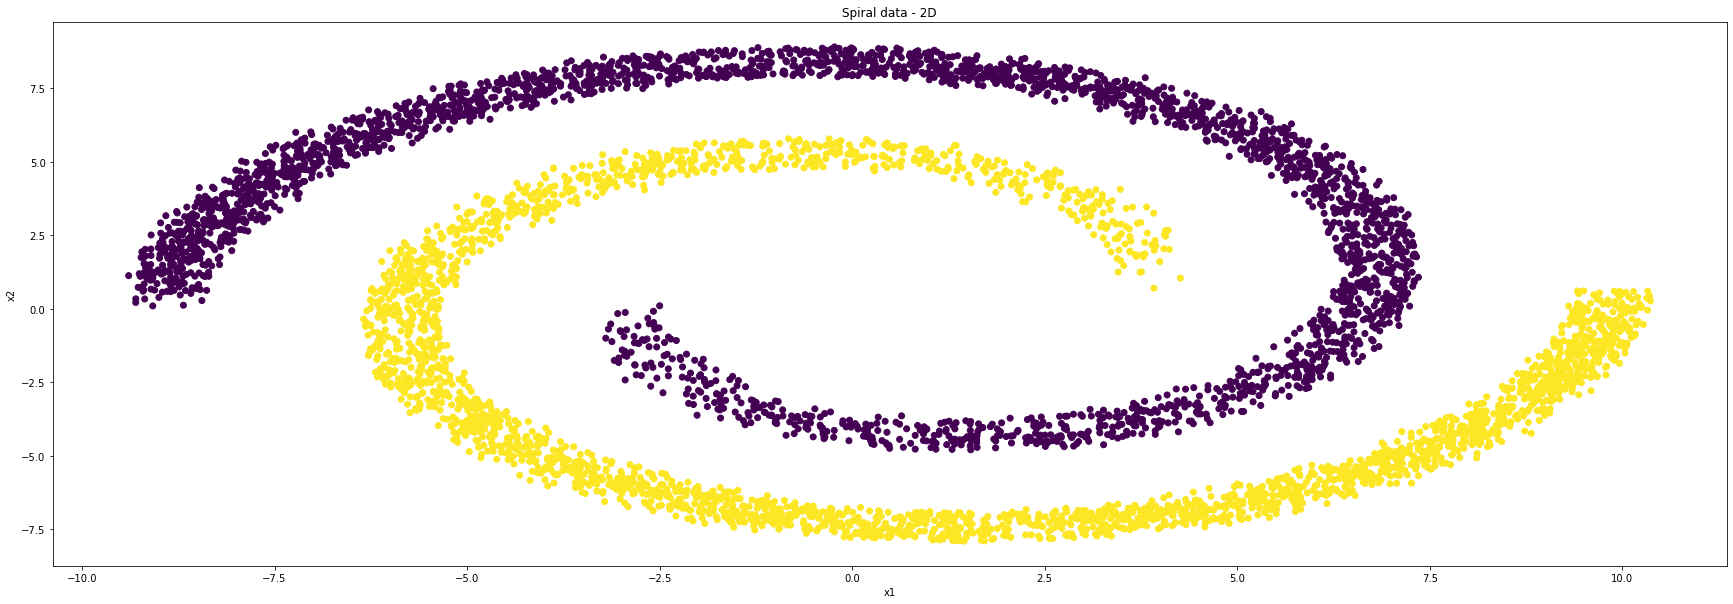

In [9]:
N_train = 3000
N_val = 1000
N_test = 500

# create data
X_train, y_train = create_spiral_data(N_train)
X_val, y_val = create_spiral_data(N_val)
X_test, y_test = create_spiral_data(N_test)

# plot train data
plot_data(X_train, y_train)

# scale data
X_train_scaled, X_val_scaled, X_test_scaled = scale(X_train, X_val, X_test)

In [10]:
# C_list = [1e-4, 1e-3, 1e-2, 0.1, 1, 10, 1e2, 1e3, 1e4]
# gamma_list = [1e-4, 1e-3, 1e-2, 0.1, 1, 10, 1e2, 1e3, 1e4]
C_list = [10]
gamma_list = [10]
train_accuracies, val_accuracies = [], []
best_val_accuracy = 50.0

for C in C_list:
  for gamma in gamma_list:
    print(f"\n * C = {C}, γ = {gamma}")

    # Create and fit mySVM model 
    my_svm = MySVM(C=C, gamma=gamma, kernel_type='rbf')
    my_svm.fit(X_train_scaled, y_train, method='dual_with_QP')

    # print train accuracy
    y_train_preds = my_svm.predict(X_train_scaled)
    train_accuracy = my_svm.get_accuracy(y_train, y_train_preds)
    print(f"Train Accuracy = {train_accuracy}")

    # print validation accuracy
    y_val_preds = my_svm.predict(X_val_scaled)
    val_accuracy = my_svm.get_accuracy(y_val, y_val_preds)
    print(f"Validation Accuracy = {val_accuracy}")
    if val_accuracy > best_val_accuracy:
      best_val_accuracy = val_accuracy
      best_model = my_svm

    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

# print test accuracy
y_test_preds = best_model.predict(X_test_scaled)
print(f"Test Accuracy = {best_model.get_accuracy(y_test, y_test_preds)}")


 * C = 10, γ = 10


/usr/local/lib/python3.8/dist-packages/qpsolvers/solvers/conversions/warnings.py:34: UserWarning: Converted P to scipy.sparse.csc.csc_matrix
For best performance, build P as a scipy.sparse.csc_matrix rather than as a numpy.ndarray
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/qpsolvers/solvers/conversions/warnings.py:34: UserWarning: Converted G to scipy.sparse.csc.csc_matrix
For best performance, build G as a scipy.sparse.csc_matrix rather than as a numpy.ndarray
  warnings.warn(


Train Accuracy = 99.96666666666667
Validation Accuracy = 100.0
Test Accuracy = 100.0


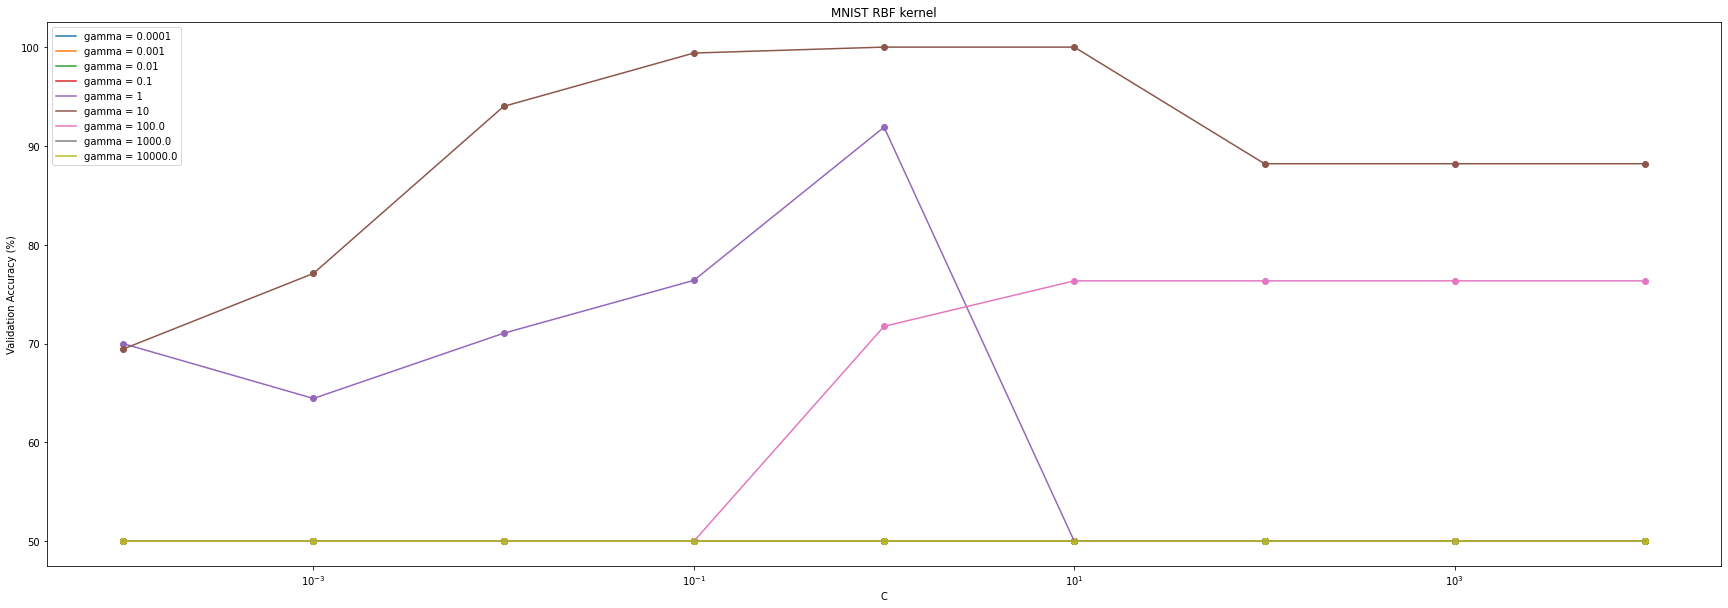

In [72]:
# each row corresponds to a 'C' and
# column to a 'gamma'
val_accuracies_arr = np.array(val_accuracies).reshape(len(C_list), len(gamma_list))

plt.figure(figsize=(30, 10))
for j, gamma in enumerate(gamma_list):
  val_acc_list = val_accuracies_arr[:, j]
  plt.plot(C_list, val_acc_list, label=f'gamma = {gamma}')
  plt.scatter(C_list, val_acc_list)

plt.xlabel('C')
plt.ylabel('Validation Accuracy (%)')
plt.title(f"Spiral data: RBF kernel")
plt.xscale('log')
plt.legend()
plt.show()

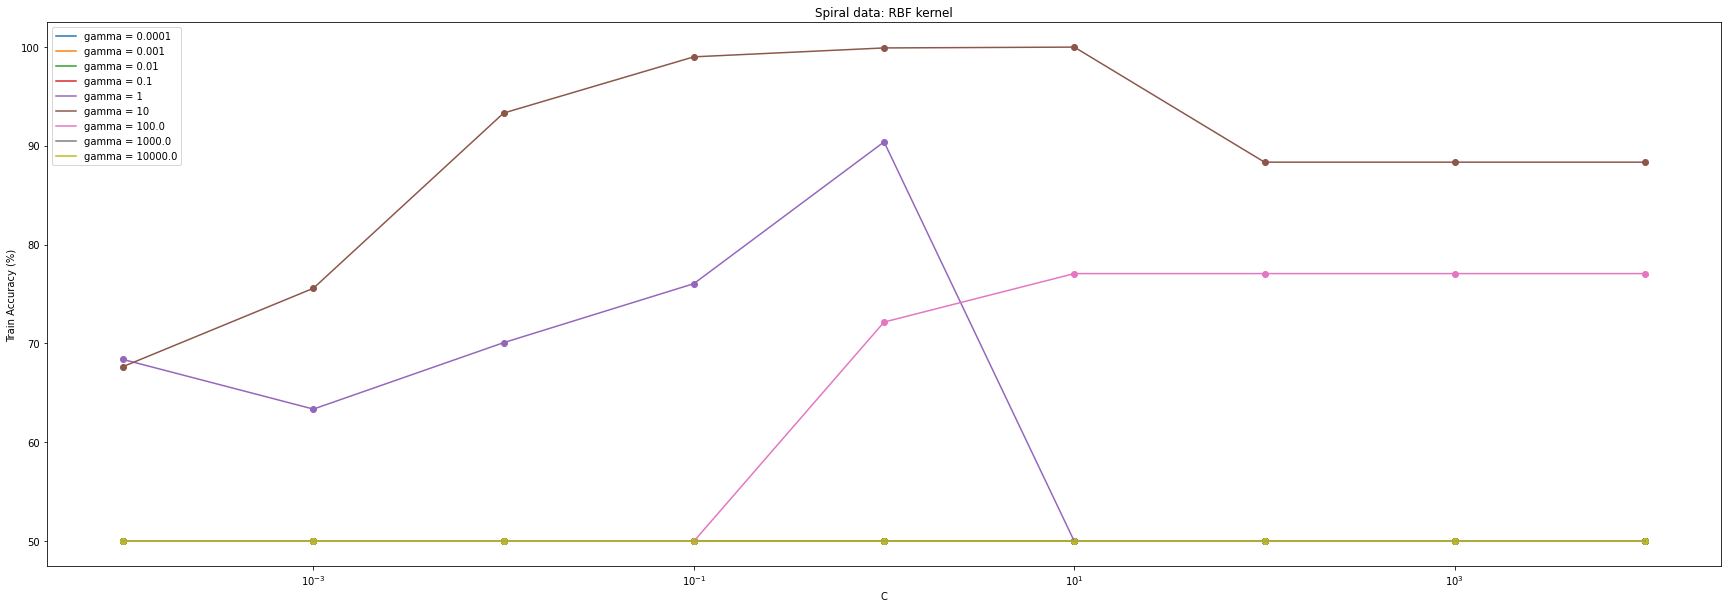

In [73]:
# each row corresponds to a 'C' and
# column to a 'gamma'
train_accuracies_arr = np.array(train_accuracies).reshape(len(C_list), len(gamma_list))

plt.figure(figsize=(30, 10))
for j, gamma in enumerate(gamma_list):
  train_acc_list = train_accuracies_arr[:, j]
  plt.plot(C_list, train_acc_list, label=f'gamma = {gamma}')
  plt.scatter(C_list, train_acc_list)

plt.xlabel('C')
plt.ylabel('Train Accuracy (%)')
plt.title(f"Spiral data: RBF kernel")
plt.xscale('log')
plt.legend()
plt.show()

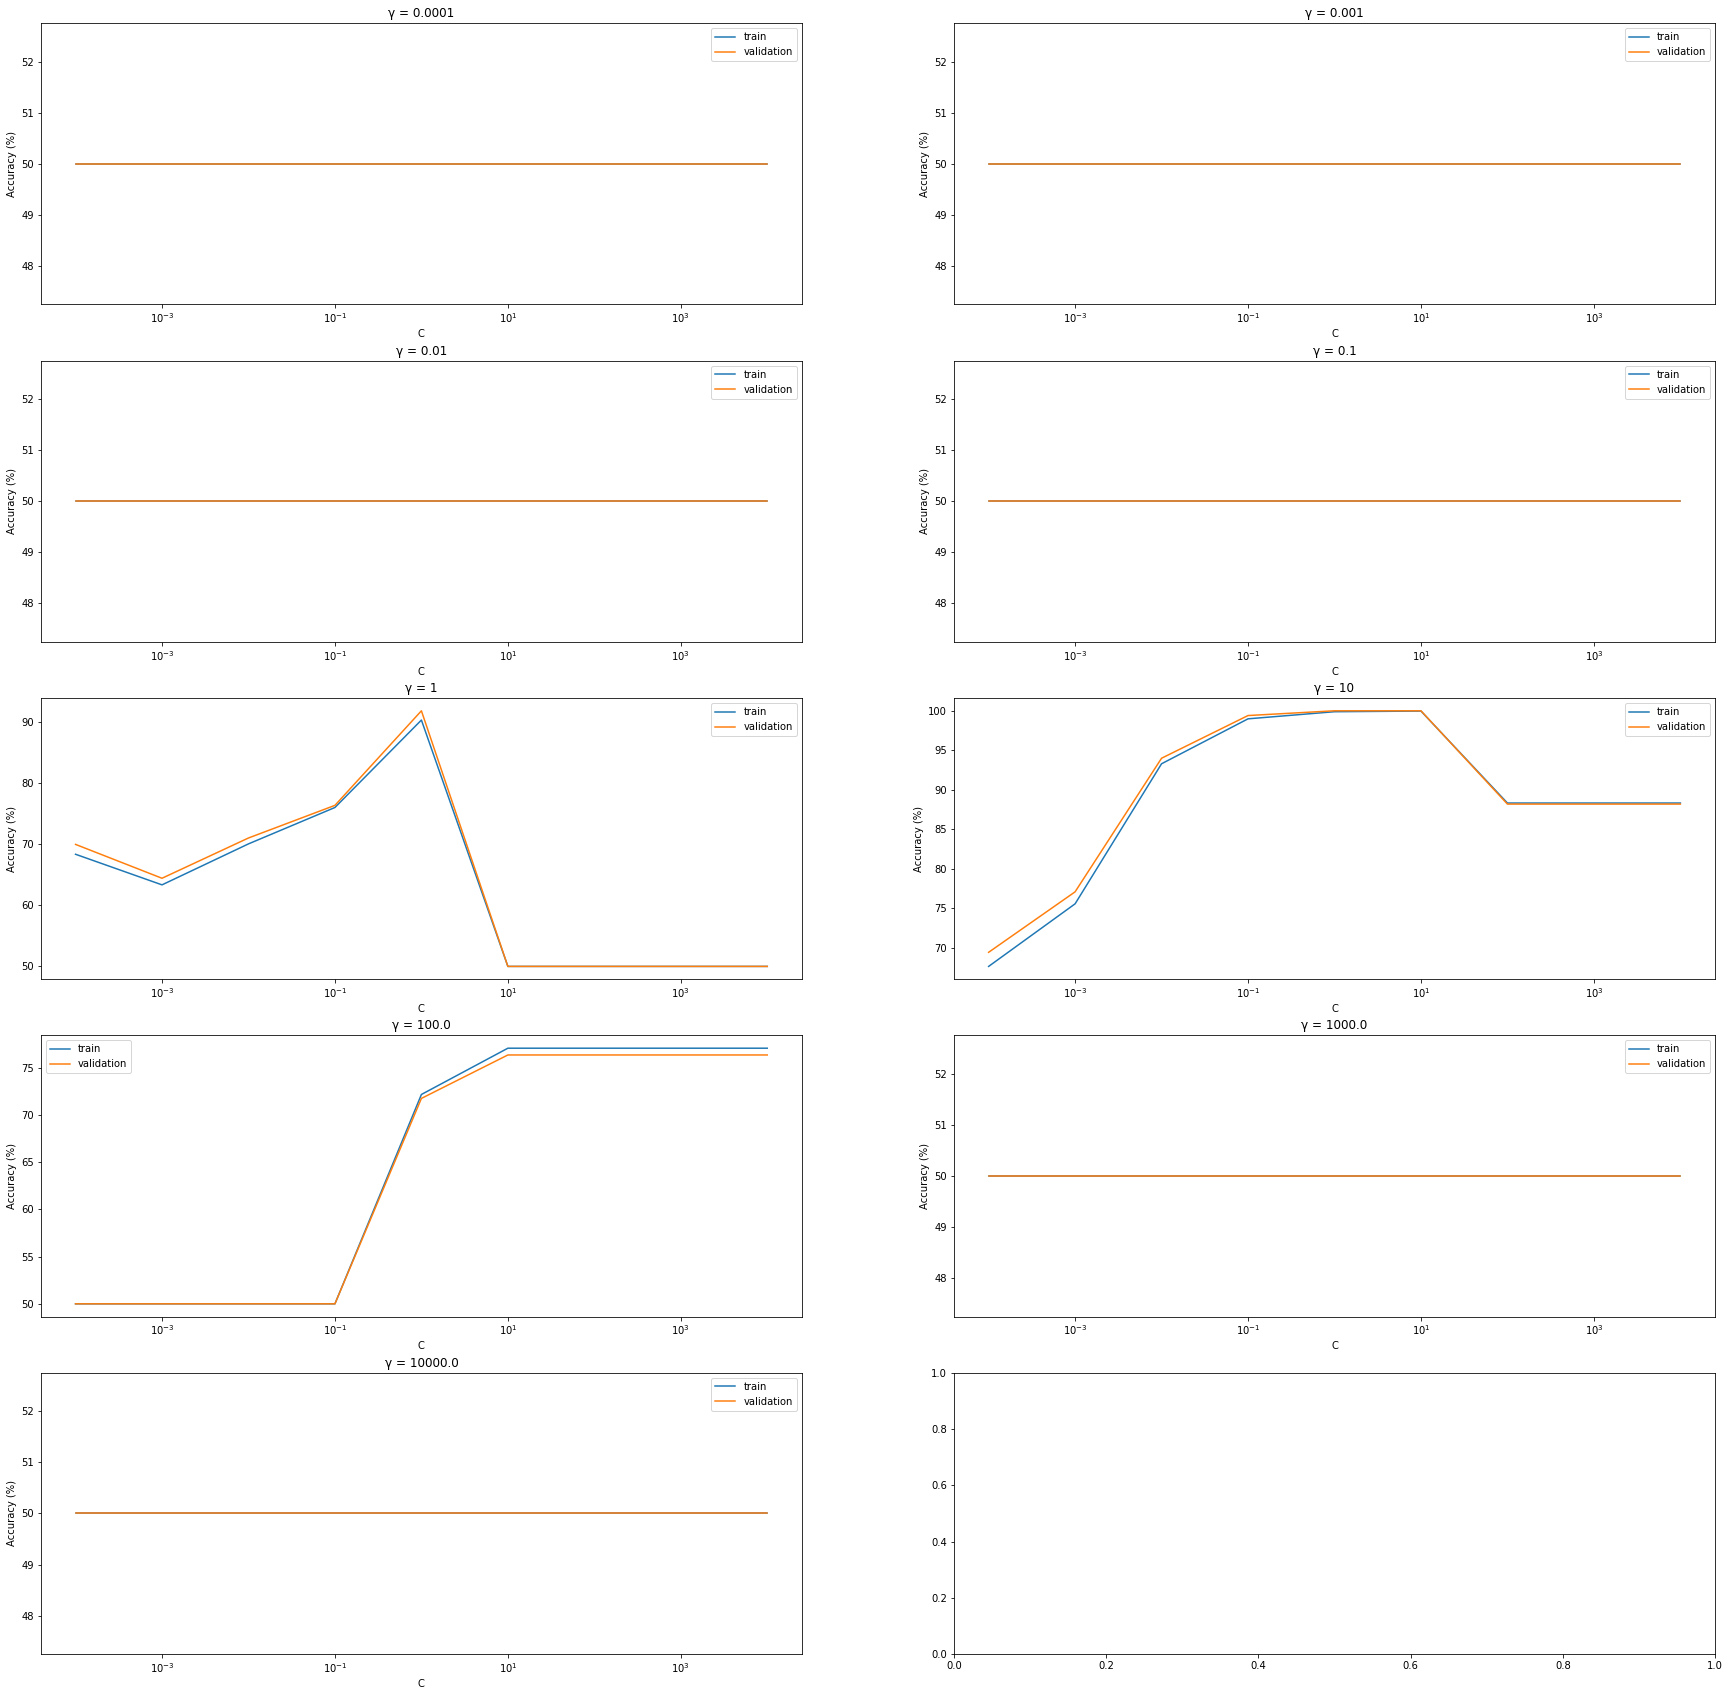

In [74]:
fig, axs = plt.subplots(5, 2, figsize=(30, 30))
for j, gamma in enumerate(gamma_list):
  train_acc_list = train_accuracies_arr[:, j]
  val_acc_list = val_accuracies_arr[:, j]
  axs[j//2, j%2].plot(C_list, train_acc_list, label='train')
  axs[j//2, j%2].plot(C_list, val_acc_list, label='validation')
  axs[j//2, j%2].set_xscale('log')
  axs[j//2, j%2].set_xlabel("C")
  axs[j//2, j%2].set_ylabel("Accuracy (%)")
  axs[j//2, j%2].set_title(f"γ = {gamma}")
  axs[j//2, j%2].legend()